In [178]:
from lstm_data_gen import * 
import numpy as np
import pandas as pd
import xgboost
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from cross_validiation_split import BlockTSSplit
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, learning_curve
from xgboost import XGBRegressor
from misc import log_return

In [2]:
btc_lstm = pd.read_pickle('btc.pkl')

last_year = btc_lstm.index[-1] - pd.Timedelta('365D')

X_lstm = btc_lstm.loc[last_year:]
X_lstm = X_lstm.drop(['volume','log_rtrn_1m'],axis=1)
print(f'X.shape :{X_lstm.shape}')
display(X_lstm.head())

cv = None

seq_length = 5
sampling_rate = 1
full = True

full_dataset = dataset_generator(X_lstm, cv, seq_length=seq_length, sampling_rate=sampling_rate, full=full)


X_lstm = full_dataset.fold_data[0]

X.shape :(525601, 8)


,open,close,high,low,ewm_21,ewm_35,ewm_80,ewm_250
2021-02-13 08:11:00,47165.0,47339.0,47339.0,47163.0,47149.738343,47227.943336,47405.920334,47627.757889
2021-02-13 08:12:00,47339.0,47268.0,47342.0,47246.0,47160.489403,47230.168707,47402.514894,47624.891292
2021-02-13 08:13:00,47264.0,47290.0,47299.0,47264.0,47172.263093,47233.492667,47399.736748,47622.222836
2021-02-13 08:14:00,47295.0,47290.0,47295.0,47287.0,47182.966449,47236.631964,47397.027199,47619.575642
2021-02-13 08:15:00,47288.0,47174.0,47292.0,47174.0,47182.151317,47233.152410,47391.520355,47616.025238


2022-07-18 16:15:19.790521: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-18 16:15:19.790576: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-18 16:15:19.790615: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mikiu-xps13): /proc/driver/nvidia/version does not exist
2022-07-18 16:15:19.791063: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
lstm_model = load_model('./saved_models/lstm_seq5_dropout.keras')

In [4]:
y_lstm = lstm_model.predict(X_lstm.train_batch)

2054/2054 [==============================] - 43s 21ms/step


In [19]:
real_targets = X_lstm.train_norm.close.shift(-1).dropna().iloc[4:-4].values
new_targets = real_targets[:,None] - y_lstm

In [6]:
lstm_model.evaluate(X_lstm.train_batch)

2054/2054 [==============================] - 46s 22ms/step - loss: 3.1400e-04 - mae: 0.0114


[0.0003140007029287517, 0.01141360867768526]

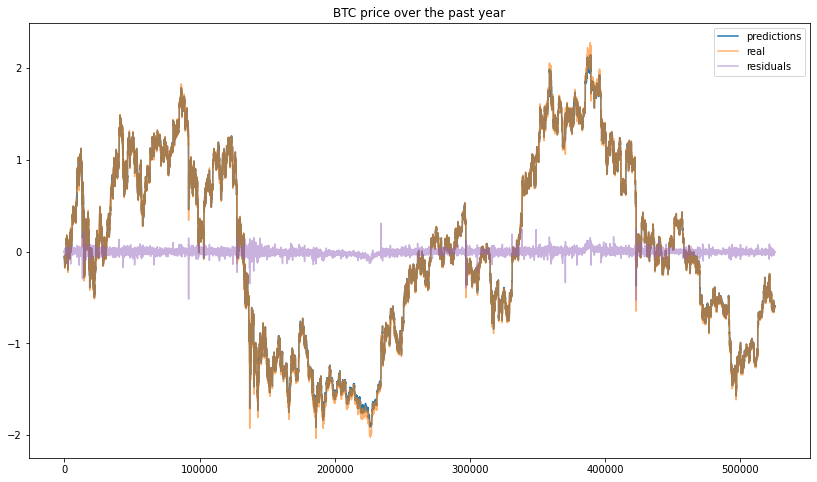

In [24]:
fig, ax = plt.subplots(figsize=(14,8))

ax.plot(y_lstm, label='predictions')
ax.plot(real_targets, label='real',alpha=0.6)
ax.plot(new_targets, label='residuals',color='tab:purple', alpha=0.5)
ax.legend()
ax.set_title('BTC price over the past year')
plt.show()


From the residuals we can see that the model is far away from the real values when there are quick large changes in the price. Hence for the XGBoost model the features should be engineered to best mimic these large changes. 

In [26]:
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [27]:
btc_xgboost = pd.read_pickle('./btc_lgbm.pkl')

In [31]:
from sklearn.preprocessing import StandardScaler

In [38]:
real_targets.shape

(525592,)

In [50]:
print(X_lstm.train.shape)
print(X_lstm.train_norm.shape)
print(btc_xgboost.loc[last_year:].shape)
print(real_targets.shape)

(525601, 8)
(525601, 8)
(525602, 14)
(525592,)


In [56]:
X_lstm.train.index[-1]

Timestamp('2022-02-13 08:11:00', freq='60S')

In [58]:
btc_lstm.index[-1]

Timestamp('2022-02-13 08:11:00', freq='60S')

In [74]:
X_xgb = btc_xgboost.loc[last_year:].iloc[:-2].iloc[4:-4].drop('log_rtrn',axis=1)


sc = StandardScaler()
X_new = sc.fit_transform(X_xgb)
X_new = pd.DataFrame(X_new, columns=X_xgb.columns)

In [75]:
scores = make_mi_scores(X_new, new_targets.reshape(-1))

In [78]:
scores

close            0.557079
average_price    0.554633
high             0.552487
low              0.551919
open             0.547930
log_rtrn_1m      0.137719
vol_15m          0.065122
vol_2h           0.060001
vol_gs           0.059091
volume           0.053250
vol_rs           0.037451
up_shdw          0.012842
dwn_shdw         0.011785
Name: MI Scores, dtype: float64

In [121]:
pipeline = Pipeline(steps=[('scaling', StandardScaler()), ('xgboost', XGBRegressor())])

n_splits = 10
cv_split = BlockTSSplit2(n_splits=n_splits)

In [185]:
cs = cross_val_score(pipeline, X_xgb, new_targets, cv=cv_split, scoring='neg_mean_absolute_error')

In [186]:
np.mean(cs*-1)

0.006349979499672448

In [120]:
from abc import abstractmethod

class BlockTSSplit2():
    def __init__(self, n_splits, val_prop=0.2):
        self.n_splits = n_splits
        self.val_prop = val_prop

    def split(self, df,y=None, groups=None):
        n_samples = len(df)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int((1 - self.val_prop) * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]
    
    
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

In [124]:
param_grid = {
    'xgboost__eta' : [0.1, 0.3, 0.6],
    'xgboost__max_depth' : [3, 6, 10],
    'xgboost__lambda' : [1, 2, 10],
    'xgboost__n_estimators' : [100, 500, 1000],
}

In [102]:
from sklearn.model_selection import GridSearchCV

In [127]:
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_absolute_error', cv=cv_split,verbose=2)

In [128]:
scores_grid_search = grid_search.fit(X_new, new_targets)

Fitting 10 folds for each of 81 candidates, totalling 810 fits
[CV] END xgboost__eta=0.1, xgboost__lambda=1, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.3s
[CV] END xgboost__eta=0.1, xgboost__lambda=1, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.2s
[CV] END xgboost__eta=0.1, xgboost__lambda=1, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.3s
[CV] END xgboost__eta=0.1, xgboost__lambda=1, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.3s
[CV] END xgboost__eta=0.1, xgboost__lambda=1, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.2s
[CV] END xgboost__eta=0.1, xgboost__lambda=1, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.1s
[CV] END xgboost__eta=0.1, xgboost__lambda=1, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.3s
[CV] END xgboost__eta=0.1, xgboost__lambda=1, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.5s
[CV] END xgboost__eta=0.1

[CV] END xgboost__eta=0.1, xgboost__lambda=1, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  42.7s
[CV] END xgboost__eta=0.1, xgboost__lambda=1, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  39.7s
[CV] END xgboost__eta=0.1, xgboost__lambda=1, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  38.9s
[CV] END xgboost__eta=0.1, xgboost__lambda=1, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  39.0s
[CV] END xgboost__eta=0.1, xgboost__lambda=1, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  39.9s
[CV] END xgboost__eta=0.1, xgboost__lambda=1, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  40.2s
[CV] END xgboost__eta=0.1, xgboost__lambda=1, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  39.0s
[CV] END xgboost__eta=0.1, xgboost__lambda=1, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  39.1s
[CV] END xgboost__eta=0.1, xgboost__lambda=1, xgboost__max_depth=10, xgboost__n_

[CV] END xgboost__eta=0.1, xgboost__lambda=2, xgboost__max_depth=6, xgboost__n_estimators=1000; total time=  45.2s
[CV] END xgboost__eta=0.1, xgboost__lambda=2, xgboost__max_depth=6, xgboost__n_estimators=1000; total time=  44.7s
[CV] END xgboost__eta=0.1, xgboost__lambda=2, xgboost__max_depth=6, xgboost__n_estimators=1000; total time=  45.6s
[CV] END xgboost__eta=0.1, xgboost__lambda=2, xgboost__max_depth=6, xgboost__n_estimators=1000; total time=  45.9s
[CV] END xgboost__eta=0.1, xgboost__lambda=2, xgboost__max_depth=6, xgboost__n_estimators=1000; total time=  44.6s
[CV] END xgboost__eta=0.1, xgboost__lambda=2, xgboost__max_depth=6, xgboost__n_estimators=1000; total time=  44.9s
[CV] END xgboost__eta=0.1, xgboost__lambda=2, xgboost__max_depth=10, xgboost__n_estimators=100; total time=   7.3s
[CV] END xgboost__eta=0.1, xgboost__lambda=2, xgboost__max_depth=10, xgboost__n_estimators=100; total time=   6.9s
[CV] END xgboost__eta=0.1, xgboost__lambda=2, xgboost__max_depth=10, xgboost__n_

[CV] END xgboost__eta=0.1, xgboost__lambda=10, xgboost__max_depth=6, xgboost__n_estimators=100; total time=   4.1s
[CV] END xgboost__eta=0.1, xgboost__lambda=10, xgboost__max_depth=6, xgboost__n_estimators=100; total time=   4.2s
[CV] END xgboost__eta=0.1, xgboost__lambda=10, xgboost__max_depth=6, xgboost__n_estimators=100; total time=   3.8s
[CV] END xgboost__eta=0.1, xgboost__lambda=10, xgboost__max_depth=6, xgboost__n_estimators=100; total time=   3.7s
[CV] END xgboost__eta=0.1, xgboost__lambda=10, xgboost__max_depth=6, xgboost__n_estimators=500; total time=  23.3s
[CV] END xgboost__eta=0.1, xgboost__lambda=10, xgboost__max_depth=6, xgboost__n_estimators=500; total time=  22.4s
[CV] END xgboost__eta=0.1, xgboost__lambda=10, xgboost__max_depth=6, xgboost__n_estimators=500; total time=  24.2s
[CV] END xgboost__eta=0.1, xgboost__lambda=10, xgboost__max_depth=6, xgboost__n_estimators=500; total time=  22.7s
[CV] END xgboost__eta=0.1, xgboost__lambda=10, xgboost__max_depth=6, xgboost__n_

[CV] END xgboost__eta=0.3, xgboost__lambda=1, xgboost__max_depth=3, xgboost__n_estimators=500; total time=  11.8s
[CV] END xgboost__eta=0.3, xgboost__lambda=1, xgboost__max_depth=3, xgboost__n_estimators=500; total time=  11.3s
[CV] END xgboost__eta=0.3, xgboost__lambda=1, xgboost__max_depth=3, xgboost__n_estimators=500; total time=  11.1s
[CV] END xgboost__eta=0.3, xgboost__lambda=1, xgboost__max_depth=3, xgboost__n_estimators=1000; total time=  24.0s
[CV] END xgboost__eta=0.3, xgboost__lambda=1, xgboost__max_depth=3, xgboost__n_estimators=1000; total time=  24.1s
[CV] END xgboost__eta=0.3, xgboost__lambda=1, xgboost__max_depth=3, xgboost__n_estimators=1000; total time=  24.1s
[CV] END xgboost__eta=0.3, xgboost__lambda=1, xgboost__max_depth=3, xgboost__n_estimators=1000; total time=  24.5s
[CV] END xgboost__eta=0.3, xgboost__lambda=1, xgboost__max_depth=3, xgboost__n_estimators=1000; total time=  24.3s
[CV] END xgboost__eta=0.3, xgboost__lambda=1, xgboost__max_depth=3, xgboost__n_esti

[CV] END xgboost__eta=0.3, xgboost__lambda=1, xgboost__max_depth=10, xgboost__n_estimators=1000; total time=  26.2s
[CV] END xgboost__eta=0.3, xgboost__lambda=2, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.5s
[CV] END xgboost__eta=0.3, xgboost__lambda=2, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.3s
[CV] END xgboost__eta=0.3, xgboost__lambda=2, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   3.0s
[CV] END xgboost__eta=0.3, xgboost__lambda=2, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.5s
[CV] END xgboost__eta=0.3, xgboost__lambda=2, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.4s
[CV] END xgboost__eta=0.3, xgboost__lambda=2, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.2s
[CV] END xgboost__eta=0.3, xgboost__lambda=2, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.4s
[CV] END xgboost__eta=0.3, xgboost__lambda=2, xgboost__max_depth=3, xgboost__n_estimat

[CV] END xgboost__eta=0.3, xgboost__lambda=2, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  30.3s
[CV] END xgboost__eta=0.3, xgboost__lambda=2, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  39.8s
[CV] END xgboost__eta=0.3, xgboost__lambda=2, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  29.2s
[CV] END xgboost__eta=0.3, xgboost__lambda=2, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  22.4s
[CV] END xgboost__eta=0.3, xgboost__lambda=2, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  24.9s
[CV] END xgboost__eta=0.3, xgboost__lambda=2, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  29.5s
[CV] END xgboost__eta=0.3, xgboost__lambda=2, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  32.1s
[CV] END xgboost__eta=0.3, xgboost__lambda=2, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  27.5s
[CV] END xgboost__eta=0.3, xgboost__lambda=2, xgboost__max_depth=10, xgboost__n_

[CV] END xgboost__eta=0.3, xgboost__lambda=10, xgboost__max_depth=6, xgboost__n_estimators=1000; total time=  48.1s
[CV] END xgboost__eta=0.3, xgboost__lambda=10, xgboost__max_depth=6, xgboost__n_estimators=1000; total time=  39.6s
[CV] END xgboost__eta=0.3, xgboost__lambda=10, xgboost__max_depth=6, xgboost__n_estimators=1000; total time=  43.6s
[CV] END xgboost__eta=0.3, xgboost__lambda=10, xgboost__max_depth=6, xgboost__n_estimators=1000; total time=  47.0s
[CV] END xgboost__eta=0.3, xgboost__lambda=10, xgboost__max_depth=6, xgboost__n_estimators=1000; total time=  48.1s
[CV] END xgboost__eta=0.3, xgboost__lambda=10, xgboost__max_depth=6, xgboost__n_estimators=1000; total time=  44.7s
[CV] END xgboost__eta=0.3, xgboost__lambda=10, xgboost__max_depth=6, xgboost__n_estimators=1000; total time=  46.9s
[CV] END xgboost__eta=0.3, xgboost__lambda=10, xgboost__max_depth=10, xgboost__n_estimators=100; total time=   8.0s
[CV] END xgboost__eta=0.3, xgboost__lambda=10, xgboost__max_depth=10, xg

[CV] END xgboost__eta=0.6, xgboost__lambda=1, xgboost__max_depth=6, xgboost__n_estimators=100; total time=   4.7s
[CV] END xgboost__eta=0.6, xgboost__lambda=1, xgboost__max_depth=6, xgboost__n_estimators=100; total time=   5.0s
[CV] END xgboost__eta=0.6, xgboost__lambda=1, xgboost__max_depth=6, xgboost__n_estimators=100; total time=   4.8s
[CV] END xgboost__eta=0.6, xgboost__lambda=1, xgboost__max_depth=6, xgboost__n_estimators=100; total time=   4.7s
[CV] END xgboost__eta=0.6, xgboost__lambda=1, xgboost__max_depth=6, xgboost__n_estimators=100; total time=   4.7s
[CV] END xgboost__eta=0.6, xgboost__lambda=1, xgboost__max_depth=6, xgboost__n_estimators=500; total time=  24.0s
[CV] END xgboost__eta=0.6, xgboost__lambda=1, xgboost__max_depth=6, xgboost__n_estimators=500; total time=  24.1s
[CV] END xgboost__eta=0.6, xgboost__lambda=1, xgboost__max_depth=6, xgboost__n_estimators=500; total time=  25.3s
[CV] END xgboost__eta=0.6, xgboost__lambda=1, xgboost__max_depth=6, xgboost__n_estimator

[CV] END xgboost__eta=0.6, xgboost__lambda=2, xgboost__max_depth=3, xgboost__n_estimators=500; total time=  11.4s
[CV] END xgboost__eta=0.6, xgboost__lambda=2, xgboost__max_depth=3, xgboost__n_estimators=500; total time=  11.3s
[CV] END xgboost__eta=0.6, xgboost__lambda=2, xgboost__max_depth=3, xgboost__n_estimators=500; total time=  11.1s
[CV] END xgboost__eta=0.6, xgboost__lambda=2, xgboost__max_depth=3, xgboost__n_estimators=1000; total time=  23.9s
[CV] END xgboost__eta=0.6, xgboost__lambda=2, xgboost__max_depth=3, xgboost__n_estimators=1000; total time=  22.5s
[CV] END xgboost__eta=0.6, xgboost__lambda=2, xgboost__max_depth=3, xgboost__n_estimators=1000; total time=  29.2s
[CV] END xgboost__eta=0.6, xgboost__lambda=2, xgboost__max_depth=3, xgboost__n_estimators=1000; total time=  26.7s
[CV] END xgboost__eta=0.6, xgboost__lambda=2, xgboost__max_depth=3, xgboost__n_estimators=1000; total time=  22.9s
[CV] END xgboost__eta=0.6, xgboost__lambda=2, xgboost__max_depth=3, xgboost__n_esti

[CV] END xgboost__eta=0.6, xgboost__lambda=2, xgboost__max_depth=10, xgboost__n_estimators=1000; total time=  20.7s
[CV] END xgboost__eta=0.6, xgboost__lambda=10, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.4s
[CV] END xgboost__eta=0.6, xgboost__lambda=10, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.4s
[CV] END xgboost__eta=0.6, xgboost__lambda=10, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   3.0s
[CV] END xgboost__eta=0.6, xgboost__lambda=10, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.5s
[CV] END xgboost__eta=0.6, xgboost__lambda=10, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.4s
[CV] END xgboost__eta=0.6, xgboost__lambda=10, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.3s
[CV] END xgboost__eta=0.6, xgboost__lambda=10, xgboost__max_depth=3, xgboost__n_estimators=100; total time=   2.4s
[CV] END xgboost__eta=0.6, xgboost__lambda=10, xgboost__max_depth=3, xgboost__n

[CV] END xgboost__eta=0.6, xgboost__lambda=10, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  27.9s
[CV] END xgboost__eta=0.6, xgboost__lambda=10, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  23.7s
[CV] END xgboost__eta=0.6, xgboost__lambda=10, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  30.0s
[CV] END xgboost__eta=0.6, xgboost__lambda=10, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  22.0s
[CV] END xgboost__eta=0.6, xgboost__lambda=10, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  16.8s
[CV] END xgboost__eta=0.6, xgboost__lambda=10, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  18.3s
[CV] END xgboost__eta=0.6, xgboost__lambda=10, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  21.7s
[CV] END xgboost__eta=0.6, xgboost__lambda=10, xgboost__max_depth=10, xgboost__n_estimators=500; total time=  23.8s
[CV] END xgboost__eta=0.6, xgboost__lambda=10, xgboost__max_depth=10, xg

In [134]:
print("Best accuracy obtained: {0}".format(scores_grid_search.best_score_))
print("Parameters:")
for key, value in scores_grid_search.best_params_.items():
    print("\t{}: {}".format(key, value))

Best accuracy obtained: -0.005568739909547321
Parameters:
	xgboost__eta: 0.1
	xgboost__lambda: 10
	xgboost__max_depth: 6
	xgboost__n_estimators: 100


In [145]:
scores_grid_search.cv_results_['mean_test_score']

array([-0.00567987, -0.00608488, -0.00633071, -0.00574416, -0.00616269,
       -0.00633532, -0.0060882 , -0.00640429, -0.00646801, -0.0057477 ,
       -0.00594279, -0.0063122 , -0.00557192, -0.00592372, -0.00607545,
       -0.00582072, -0.00620575, -0.00628748, -0.00573681, -0.00571809,
       -0.00581805, -0.00556874, -0.0057554 , -0.00590021, -0.00592121,
       -0.00629904, -0.00642758, -0.00583226, -0.00662683, -0.00683811,
       -0.00634998, -0.00682284, -0.00695876, -0.00680752, -0.00706039,
       -0.00706039, -0.00569071, -0.00632228, -0.00665463, -0.00589816,
       -0.00626895, -0.00643841, -0.00634679, -0.00657338, -0.00657338,
       -0.0057153 , -0.00599055, -0.00637775, -0.00577384, -0.00618781,
       -0.0063286 , -0.00637637, -0.00669947, -0.00670366, -0.00694314,
       -0.00827652, -0.00843114, -0.0068019 , -0.00740613, -0.00751581,
       -0.00722177, -0.00737652, -0.00737652, -0.00638522, -0.00706448,
       -0.00742884, -0.00710452, -0.00766812, -0.00775392, -0.00

In [141]:
scores_grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_xgboost__eta', 'param_xgboost__lambda', 'param_xgboost__max_depth', 'param_xgboost__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [143]:
scores_grid_search.cv_results_['params'][21]

{'xgboost__eta': 0.1,
 'xgboost__lambda': 10,
 'xgboost__max_depth': 6,
 'xgboost__n_estimators': 100}

### Baseline

In [187]:
best_params = {'eta': 0.1,
               'lambda': 10,
               'max_depth': 6,
               'n_estimators': 100,
              }

xgb_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                          ('xgboost', XGBRegressor(**best_params))])

n_folds = 10
expanding_cv = TimeSeriesSplit(n_splits=n_folds)

expanding_cv_scores = cross_val_score(xgb_pipe, X_xgb, new_targets, cv=expanding_cv, 
                                      scoring='neg_mean_absolute_error', verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   6.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV] END .................................................... total time=  12.9s
[CV] END .................................................... total time=  20.8s
[CV] END .................................................... total time=  28.0s
[CV] END .................................................... total time=  39.8s
[CV] END .................................................... total time=  45.7s
[CV] END .................................................... total time=  57.8s
[CV] END .................................................... total time= 1.1min
[CV] END .................................................... total time=  57.0s
[CV] END .................................................... total time= 1.0min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  6.6min finished


In [166]:
np.mean(-1*expanding_cv_scores)

0.005307309358900042

In [155]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 10),
):
    
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")
    return plt


<module 'matplotlib.pyplot' from '/home/mikiu/anaconda3/envs/crypt_venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

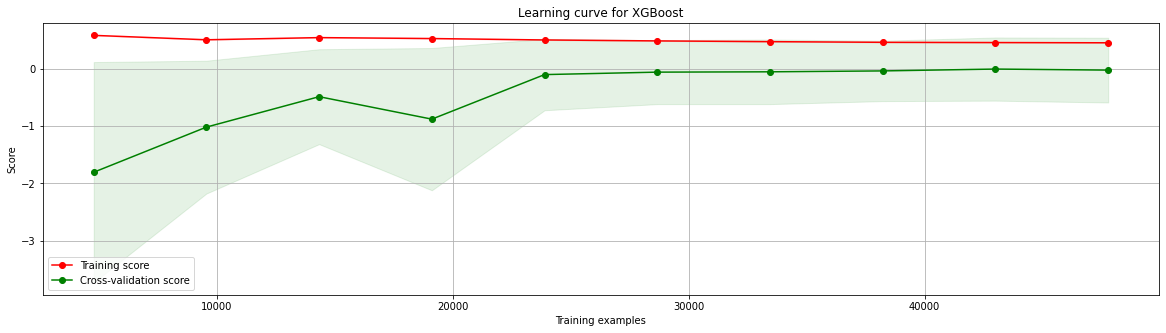

In [156]:
plot_learning_curve(xgb_pipe, 'Learning curve for XGBoost', X_xgb, new_targets, cv=expanding_cv)

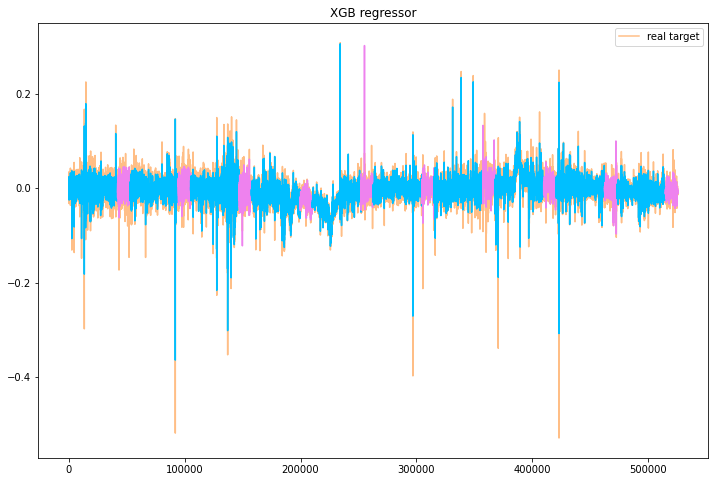

In [190]:
best_params = {'eta': 0.1,
               'lambda': 10,
               'max_depth': 6,
               'n_estimators': 100,
              }

block_cv = BlockTSSplit2(n_splits=10)

predicted = list()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(new_targets, color='tab:orange', alpha=0.5, label='real target')

for train, val in block_cv.split(X_xgb):
    X_train = X_xgb.iloc[train]
    y_train = new_targets[train]
    
    X_val = X_xgb.iloc[val]
    y_val = new_targets[val]
    
    xgb_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                          ('xgboost', XGBRegressor(**best_params))])
    
    xgb_pipe.fit(X_train, y_train)
    train_predict = xgb_pipe.predict(X_train)
    ax.plot(train, train_predict, color='deepskyblue')
    
    val_predict = xgb_pipe.predict(X_val)
    ax.plot(val, val_predict, color='violet')
    
ax.set_title('XGB regressor')
ax.legend()
plt.show()



Still missing out on a lot of the sharp spikes, which is what we care about. 

## Improving the baseline

In [191]:
best_params = {'eta': 0.1,
               'lambda': 10,
               'max_depth': 6,
               'n_estimators': 100,
              }

xgb_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                          ('xgboost', XGBRegressor(**best_params))])

block_cv = BlockTSSplit2(n_splits=10)

#### Baseline

In [192]:
np.mean(-1* cross_val_score(xgb_pipe, X_xgb, new_targets, cv=block_cv, scoring='neg_mean_absolute_error'))

0.005568739909547321

#### Drop
Dropping a few of the columns to see if the signal/noise ratio is improved

In [193]:
mae = list()

for column in X_new.columns:
    print(f'column dropped: {column}')
    temp = -1*cross_val_score(xgb_pipe, X_xgb.drop(column, axis=1), new_targets, cv=block_cv, 
                                      scoring='neg_mean_absolute_error')
    mae.append([np.mean(temp), np.std(temp)])
    print(f'mae: {np.mean(temp)}')
    print('\n')

column dropped: open
mae: 0.005572882051250873


column dropped: close
mae: 0.0056081749883188925


column dropped: high
mae: 0.005562270394708501


column dropped: low
mae: 0.005593265971139148


column dropped: volume
mae: 0.00565732414078973


column dropped: log_rtrn_1m
mae: 0.007244383761374189


column dropped: average_price
mae: 0.005581963424192776


column dropped: up_shdw
mae: 0.00558892650204945


column dropped: dwn_shdw
mae: 0.005607690233875441


column dropped: vol_15m
mae: 0.006245680553392618


column dropped: vol_2h
mae: 0.0055830029271934905


column dropped: vol_gs
mae: 0.005565488651148158


column dropped: vol_rs
mae: 0.005570435729454884




Huge increase in the error when the 1min log return was dropped as well as the 15min volatility! 
Let's investigate the inclusion of more short term features. 
Firstly though, to speed up the evaluation most of the columns will be dropped. 

In [194]:
np.mean(-1* cross_val_score(xgb_pipe, X_xgb[['vol_15m', 'log_rtrn_1m','close',
                                             'volume','dwn_shdw']], new_targets, cv=block_cv, 
                           scoring='neg_mean_absolute_error'))

0.005705886238620722

In [198]:
btc_xgboost['log_rtrn_5m'] = log_return(btc_xgboost.close, periods=5)
btc_xgboost['vol_5m'] = btc_xgboost.close.rolling(5, min_periods=1).std()

In [199]:
columns = ['vol_15m', 'log_rtrn_1m','close','volume','dwn_shdw', 'log_rtrn_5m', 'vol_5m']
X_xgb_new = btc_xgboost[columns].loc[last_year:].iloc[:-2].iloc[4:-4]

In [200]:
np.mean(-1 * cross_val_score(xgb_pipe, X_xgb_new, new_targets, cv=block_cv, scoring='neg_mean_absolute_error'))

0.0047479459301410796

#### Huge improvement!

In [203]:
btc_xgboost['log_rtrn_2m'] = log_return(btc_xgboost.close, periods=2)
columns.append('log_rtrn_2m')
X_xgb_new = btc_xgboost[columns].loc[last_year:].iloc[:-2].iloc[4:-4]
np.mean(-1 * cross_val_score(xgb_pipe, X_xgb_new, new_targets, cv=block_cv, scoring='neg_mean_absolute_error'))

0.004657041223176736

In [204]:
X_xgb_new

,vol_15m,log_rtrn_1m,close,volume,dwn_shdw,log_rtrn_5m,vol_5m,log_rtrn_15m,log_rtrn_2m
2021-02-13 08:15:00,171.406645,-0.002456,47174.000000,3.889543,0.000000,0.000085,60.738786,0.000848,-0.002456
2021-02-13 08:16:00,173.034540,0.000318,47189.000000,4.754135,0.000000,-0.003174,56.384396,0.001591,-0.002138
2021-02-13 08:17:00,176.282565,0.000911,47232.000000,10.283806,20.000000,-0.000762,54.534394,0.002459,0.001229
2021-02-13 08:18:00,175.544404,0.001904,47322.000000,5.587356,0.000000,0.000676,63.708713,0.008638,0.002814
2021-02-13 08:19:00,138.470110,-0.000254,47310.000000,1.571439,28.000000,0.000423,68.005883,0.012464,0.001650
...,...,...,...,...,...,...,...,...,...
2022-02-13 08:02:00,19.764741,0.000424,42432.000000,0.391022,0.000000,-0.000306,15.189387,0.000896,-0.000118
2022-02-13 08:03:00,16.202135,0.000283,42444.000000,0.813080,2.319708,-0.000165,13.817557,0.001166,0.000707
2022-02-13 08:04:00,11.839045,0.000011,42444.478745,2.934302,0.478745,-0.000134,12.473641,0.001072,0.000294
2022-02-13 08:05:00,11.573706,-0.000011,42444.000000,4.072066,0.000000,0.000165,13.223335,0.000259,0.000000


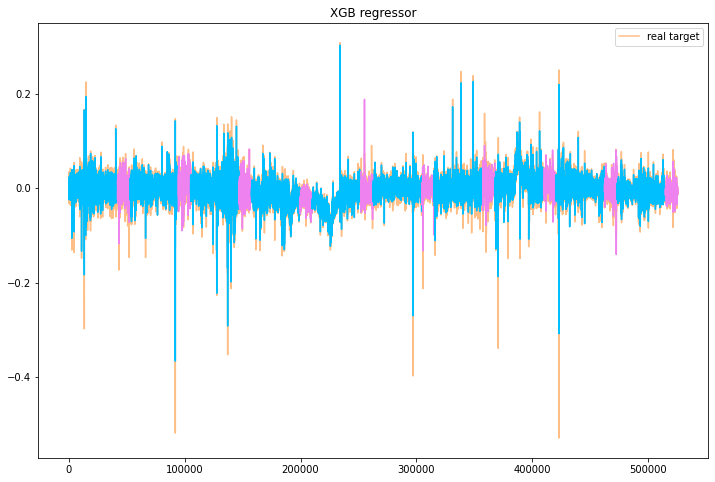

In [205]:
best_params = {'eta': 0.1,
               'lambda': 10,
               'max_depth': 6,
               'n_estimators': 100,
              }

block_cv = BlockTSSplit2(n_splits=10)

predicted = list()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(new_targets, color='tab:orange', alpha=0.5, label='real target')

for train, val in block_cv.split(X_xgb_new):
    X_train = X_xgb_new.iloc[train]
    y_train = new_targets[train]
    
    X_val = X_xgb_new.iloc[val]
    y_val = new_targets[val]
    
    xgb_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                          ('xgboost', XGBRegressor(**best_params))])
    
    xgb_pipe.fit(X_train, y_train)
    train_predict = xgb_pipe.predict(X_train)
    ax.plot(train, train_predict, color='deepskyblue')
    
    val_predict = xgb_pipe.predict(X_val)
    ax.plot(val, val_predict, color='violet')
    
ax.set_title('XGB regressor')
ax.legend()
plt.show()



Still some work to be done regarding the spikes!

### Inspecting the full predictions 

In [206]:
best_params = {'eta': 0.1,
               'lambda': 10,
               'max_depth': 6,
               'n_estimators': 100,
              }


xgb_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                          ('xgboost', XGBRegressor(**best_params))])

xgb_pipe.fit(X_xgb_new, new_targets)

xgb_preds = xgb_pipe.predict(X_xgb_new)

In [216]:
total_preds = y_lstm.reshape(-1) + xgb_preds

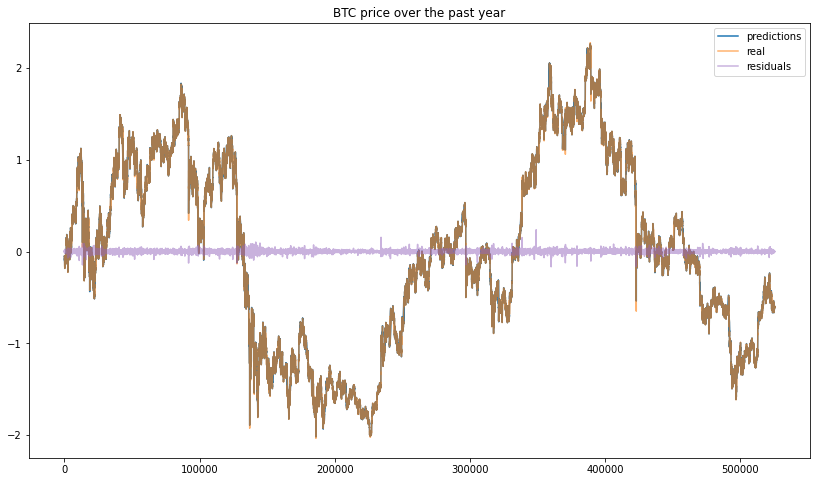

In [218]:
fig, ax = plt.subplots(figsize=(14,8))

ax.plot(total_preds, label='predictions')
ax.plot(real_targets, label='real',alpha=0.6)
ax.plot(real_targets - total_preds, label='residuals',color='tab:purple', alpha=0.5)
ax.legend()
ax.set_title('BTC price over the past year')
plt.show()


In [219]:
np.mean(np.abs(real_targets - total_preds))

0.0038157023978861878

In [233]:
np.mean(np.abs(real_targets[:-1] - np.roll(real_targets, -1)[:-1]))

0.0035998453847098312

### Nearly better than the common sense baseline!